<a href="https://colab.research.google.com/github/jonkrohn/DLTFpT/blob/master/notebooks/dense_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Activity Classifier - Hand Location


In this notebook, we build a dense neural net to classify PE activity.

#### Load dependencies

In [3]:
import tensorflow
from tensorflow.keras.datasets import imdb # new!  # delete later
from tensorflow.keras.preprocessing.sequence import pad_sequences #new!
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding # new!
from tensorflow.keras.callbacks import ModelCheckpoint # new! 
from sklearn.metrics import confusion_matrix
import os # new! 
from sklearn.metrics import roc_auc_score, roc_curve # new!
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # new!

In [4]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tensorflow.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11652798458045970902
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6557934077390148532
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4022219571
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8386320996730511532
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6882945954167579664
physical_device_desc: "device: XLA_GPU device"
]
# GPUs Available:  1


'2.3.1'

#### Set hyperparameters

In [5]:
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder()
# encoder.fit(label_array)
# encoder.categories_

# label_array.shape

In [6]:
# output directory name:
output_dir = 'model_output/hand/dense'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/hand/'
input_file_name = 'hand-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency




# convolutional layer architecture:
n_conv = 64 # filters, a.k.a. kernels
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 256
dropout = 0.2

# training:
epochs = 30
batch_size = 128


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [7]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [8]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [9]:
# change from string to integer so keras.to_categorical can consume it

# could do with factorize method as well
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)
print(class_list)

# check if the result is consistant with the original input
class_list[labels_array_int].reshape(len(labels_array_int), 1) == labels_array

# Note to get the reverse, i.e converting integer array to string use class_list[labels_array_int]

['Lying' 'Running 3 METs' 'Running 5 METs' 'Running 7 METs'
 'Self Pace walk' 'Sitting']


array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [10]:
# labels to categorical

y = to_categorical(labels_array_int, num_classes=n_class)
input_shape = list(accel_array.shape)


#### Design neural network architecture

In [11]:
# a conv model!

model = Sequential()
model.add(Conv1D(n_conv, k_conv, activation='relu', input_shape=input_shape[1:]))
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(n_class, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 64)            640       
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

### Splitting and shuffeling the data

In [13]:
# split and shuffle
x_train, x_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)

#### Configure model

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [15]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [16]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [17]:
import tensorflow as tf
tf.test.gpu_device_name()
tf.__version__
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((58253, 90, 3), (58253, 6), (6473, 90, 3), (6473, 6))

#### Train!

In [34]:
model.fit(x_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(x_valid, y_valid), 
         callbacks=[modelcheckpoint])

# model.fit(x_train, y_train, 
#           batch_size=batch_size, epochs=epochs, verbose=1, 
#           validation_data=(x_valid, y_valid))

Epoch 1/30
456/456 [==============================] - 2s 4ms/step - loss: 0.4026 - accuracy: 0.8559 - val_loss: 0.4042 - val_accuracy: 0.8599
Epoch 2/30
456/456 [==============================] - 2s 4ms/step - loss: 0.3986 - accuracy: 0.8572 - val_loss: 0.4067 - val_accuracy: 0.8525
Epoch 3/30
456/456 [==============================] - 2s 4ms/step - loss: 0.3980 - accuracy: 0.8573 - val_loss: 0.4057 - val_accuracy: 0.8518
Epoch 4/30
456/456 [==============================] - 2s 4ms/step - loss: 0.3939 - accuracy: 0.8597 - val_loss: 0.3979 - val_accuracy: 0.8574
Epoch 5/30
456/456 [==============================] - 2s 4ms/step - loss: 0.3895 - accuracy: 0.8615 - val_loss: 0.3912 - val_accuracy: 0.8616
Epoch 6/30
456/456 [==============================] - 2s 4ms/step - loss: 0.3893 - accuracy: 0.8608 - val_loss: 0.3992 - val_accuracy: 0.8617
Epoch 7/30
456/456 [==============================] - 2s 4ms/step - loss: 0.3841 - accuracy: 0.8623 - val_loss: 0.4020 - val_accuracy: 0.8554
Epoch 

In [19]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


#### Evaluate

In [20]:
# model.load_weights(output_dir+"/weights.02.hdf5") # NOT zero-indexed

In [21]:
y_hat = model.predict(x_valid)

In [22]:
len(y_hat)

6473

In [23]:
y_hat[0]

array([1.8240751e-01, 4.8806132e-03, 3.6115699e-02, 6.1947154e-04,
       1.1884515e-03, 7.7478826e-01], dtype=float32)

In [24]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

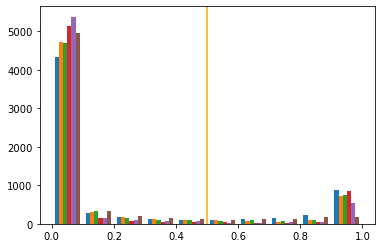

In [25]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [26]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [27]:
"{:0.2f}".format(pct_auc)

'98.09'

In [28]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [29]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [30]:
ydf.head(10)


,y_hat,y
0,0.182408,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,0.000400,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2,0.000009,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
3,0.256472,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
4,0.079760,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
5,0.000518,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
6,0.026856,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
7,0.058894,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
8,0.000602,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
9,0.329225,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [31]:
# cf_matrix = confusion_matrix(y_valid, y_hat)
# print(cf_matrix) # doesn't work coz we have probability not class
y_hat

array([[1.8240751e-01, 4.8806132e-03, 3.6115699e-02, 6.1947154e-04,
        1.1884515e-03, 7.7478826e-01],
       [4.0006201e-04, 9.2920074e-03, 1.1470251e-03, 3.1070611e-01,
        5.9882615e-04, 6.7785591e-01],
       [8.5436168e-06, 6.1120349e-04, 9.9518895e-01, 1.8734565e-03,
        2.4982762e-07, 2.3174898e-03],
       ...,
       [6.9181848e-04, 1.6310344e-02, 5.6454132e-04, 1.3947296e-04,
        9.7491044e-01, 7.3833498e-03],
       [8.0330198e-04, 1.4012869e-02, 1.9429030e-04, 2.6308567e-06,
        9.8375005e-01, 1.2368996e-03],
       [2.6565972e-01, 1.9537569e-03, 8.1373053e-04, 4.7918805e-04,
        1.5834944e-03, 7.2951001e-01]], dtype=float32)

In [32]:
# convert probability to class
y_pred_class = np.argmax(y_hat, axis=1)
y_class = np.argmax(y_valid, axis = 1)

array([[1272,   22,    6,    5,   30,   86],
       [  14,  960,   90,   11,   19,   17],
       [   7,   62,  978,   37,   18,   13],
       [  22,   11,   43,  963,   11,   10],
       [  12,   54,   25,    9,  697,   14],
       [ 217,   44,   18,   14,   18,  644]], dtype=int64)

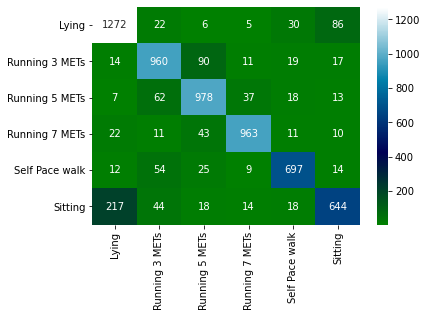

In [33]:
cf_matrix = confusion_matrix(y_class, y_pred_class, labels=range(6))
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt = '1', xticklabels=class_list, yticklabels=class_list, cmap='ocean')
cf_matrix